<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/ApproxHessian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loss Landscape

Below we show how to use **two random orthogonal directions** to visualize the loss of arbitrary networks.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

import itertools

import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
## define the LeNet5 architecture

class LeNet5(tf.keras.Model):
  ''' see https://en.wikipedia.org/wiki/Convolutional_neural_network '''

  def __init__(self):
    super(LeNet5, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(6,kernel_size=(5,5), strides=(1, 1), activation='tanh',padding='valid')
    self.avpool1 = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')
    self.conv2 = tf.keras.layers.Conv2D(16, kernel_size=(5,5), strides=(1, 1), activation='tanh', padding='valid')
    self.avpool2 = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')
    self.flatt = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(120, activation='tanh')
    self.dense2 = tf.keras.layers.Dense(84, activation='tanh')
    self.dense3 = tf.keras.layers.Dense(10, activation='linear')

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.avpool1(x)
    x = self.conv2(x)
    x = self.avpool2(x)
    x = self.flatt(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    return x

In [3]:
## prepare training data
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
x_train,x_test = np.expand_dims(x_train,-1),np.expand_dims(x_test,-1) # when black-white

data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
data = data.batch(32).prefetch(1).repeat(1)

In [4]:
## loss and train

model = LeNet5()
optimizer = tf.keras.optimizers.Adam(0.001)

@tf.function
def logp(model,x,y):
  ''' model outputs logits for prediction '''
  y_pred = model(x)
  logp = -tf.keras.losses.sparse_categorical_crossentropy(y,y_pred,from_logits=True)
  return tf.reduce_mean(logp)

@tf.function
def train_step(x,y):
  loss_fn = lambda: -logp(model,x,y)
  vars_fn = lambda: model.trainable_variables
  optimizer.minimize(loss_fn,vars_fn)

In [5]:
## utils

def random_orthogonal_pair(N):
  ''' generate randomly two orthogonal directions '''
  t = np.random.normal(size=(2,N))
  t = t/np.linalg.norm(t,axis=1,keepdims=True)
  a,b = t
  b = b-a*a.dot(b)
  b = b/np.linalg.norm(b)
  return a,b

def model2flatt(model):
  ''' model tensors to one flatt tensor '''
  return np.concatenate([t.numpy().ravel() for t in model.trainable_variables])

def flatt2model(w,shapes):
  ''' one flatt tensor to model tensors '''
  offsets = [np.prod(s) for s in shapes]
  pos_end = list(np.cumsum(offsets))
  pos_start = [0]+pos_end[:-1]
  return [w[i:j].reshape(s) for (i,j,s) in zip(pos_start,pos_end,shapes)]

def loss_on_weights(model,x,y,w):
  ''' loss depending on custom choice of weights '''
  # keep the original weights
  vals_original = [t.numpy() for t in model.trainable_variables]
  # change weigts in the model and call it
  vals = flatt2model(w,[t.shape.as_list() for t in model.trainable_variables])
  for val,var in zip(vals,model.trainable_variables):
    var.assign(val)
  out = logp(model,x,y)
  # restore the original weights
  for val,var in zip(vals_original,model.trainable_variables):
    var.assign(val)
  return out



In [6]:
## train

for i,(x,y) in enumerate(data):
  if i%100 == 0:
    print(logp(model,x_test,y_test).numpy())
  train_step(x,y)

-2.3119926
-0.7622269
-0.6667066
-0.6333814
-0.60431814
-0.5784782
-0.5637
-0.5682012
-0.5294775
-0.5262612
-0.5054925
-0.49708048
-0.5109639
-0.50220835
-0.495383
-0.4730278
-0.46201473
-0.47431216
-0.45861036


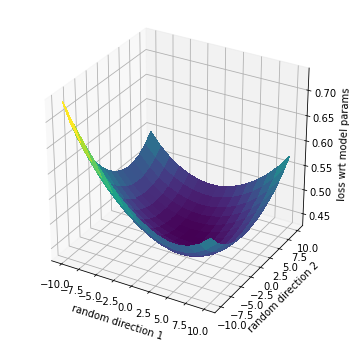

In [7]:
## compute the loss on weights along two random orthogonal dimensions!

np.random.seed(1234)
N = model.count_params()
a,b=random_orthogonal_pair(N)
w0 = model2flatt(model)

def fn(a_step,b_step):
  return loss_on_weights(model,x_test,y_test,w0+a_step*a+b_step*b)

fn = np.vectorize(fn)

xs,ys = 10*np.linspace(-1,1,15),10*np.linspace(-1,1,15)
grid = np.meshgrid(xs,ys,sparse=True)
X,Y,Z = *grid,fn(*grid)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(6,6))
ax.set_xlabel('random direction 1')
ax.set_ylabel('random direction 2')
ax.set_zlabel('loss wrt model params',rotation=90,labelpad=6)
surf = ax.plot_surface(X,Y,-Z, cmap=cm.viridis, linewidth=0, antialiased=False)
plt.show()

## Behavior of activations near 0

Classical activation functions satisfy $h''(0)=0$ or $h(x)=\Theta(x)+O(x^3)$ for small $x$. We say that they are nearly-linear around 0.

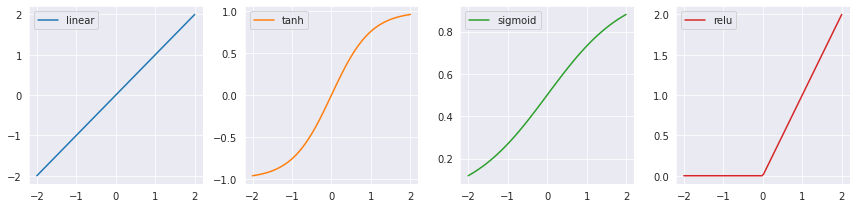

In [8]:
sn.set_style("darkgrid")
palette = itertools.cycle(sn.color_palette())

fs = [tf.keras.activations.linear,tf.keras.activations.tanh,tf.keras.activations.sigmoid,tf.keras.activations.relu]
#fs = [np.vectorize(f) for f in fs]

fig,axs = plt.subplots(1,4,figsize=(12,3))

xs = np.linspace(-2,2,100)
for (f,ax) in zip(fs,axs.ravel()):
  ax.plot(xs,f(xs),label=f.__name__,color=next(palette))
  ax.legend()

fig.tight_layout()

## Hessian Approximation

The chain rule for the hessian of neural network loss is:
$$
D^2_w \ell(z) = D_w(D_z\ell \bullet D_w z) = D^2_z\ell \bullet D_w z \bullet D_w z + D_z\ell\bullet D^2_w z
$$

The approximated chain fule would neglect the curvature contribution, giving
$$
D^2_w \ell(z) \approx D^2_z\ell \bullet D_w z \bullet D_w z 
$$

Below we test it!

In [9]:
### utils

## utils for exact hessian form

@tf.function
def logp(logits,y):
  ''' logits of shape (n_batch,n_class), y of shape (n_batch,) '''
  logp = tf.gather(logits,y,batch_dims=1) - tf.reduce_logsumexp(logits,-1) # (n_batch,)
  return tf.reduce_mean(logp) # (,)

@tf.function
def grad(model,var,x,y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss = -logp(logits,y)
  grad = tape.gradient(loss,var)
  return grad

@tf.function
def hvp(model,var,vec,x,y):
  ''' hessian-vector product; takes advantage of weighted gradient (hess is with respect to weight matrix) '''
  # second derivative (on top)
  with tf.GradientTape() as outer_tape:
    # first derivative (inner)
    with tf.GradientTape() as inner_tape:
      logits = model(x)
      loss = -logp(logits,y)
    grads = inner_tape.gradient(loss,var)
  hess_vec = outer_tape.gradient(grads,var,output_gradients=vec)
  return hess_vec

@tf.function
def hform(model,var,vec,x,y):
  ''' hessian form of model loss, with respect to variable, evaluated at vector '''
  h = hvp(model,var,vec,x,y)
  return tf.reduce_sum(vec*h)

## utils for approx hessian form

@tf.function
def jac_logits_var(model,var,x,y=None):
  ''' jacobian of logits wrt model variable '''
  with tf.GradientTape() as tape:
    logits = model(x)
  jac = tape.jacobian(logits,var)
  return jac

@tf.function
def hess_loss_logits(model,x,y):
  ''' hessian of loss wrt logits '''
  with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
      logits = model(x)
      loss=-logp(logits,y) # (n_batch,n_class)
    grads = inner_tape.gradient(loss,logits) # (n_batch,n_class)
  return outer_tape.batch_jacobian(grads,logits)  # (n_batch,n_class,n_class)

@tf.function
def hform_approx(model,var,vec,x,y):
  ''' hessian form wrt variable, evaluated on vector; approximate '''
  H = hess_loss_logits(model,x,y) # (n_batch,n_class,n_class)
  J = jac_logits_var(model,var,x) # (n_batch,n_class,var.shape)
  vec = grad(model,var,x,y) # (var.shape,)
  #J_dot_vec = tf.einsum('abcd,cd->ab',J,vec) # (n_batch,n_class)
  axes = [range(2,2+len(vec.shape)),range(len(vec.shape))]
  J_dot_vec = tf.tensordot(J,vec,axes=axes)
  Hform = tf.einsum('xab,xa,xb->',H,J_dot_vec,J_dot_vec)
  return Hform

## utils to refresh initialization

def reset_kernels(model):
  for l in model.layers:
    if hasattr(l,'kernel'):
      l.kernel.assign(l.kernel_initializer(l.kernel.shape))

In [10]:
## define approximation error

@tf.function
def happrox_error(model,var,x,y):
  vec = grad(model,var,x,y) 
  vec_norm = tf.linalg.norm(vec)
  h_exact = hform(model,var,vec,x,y)
  h_approx = hform_approx(model,var,vec,x,y)
  error = tf.abs(h_approx-h_exact) / tf.square(vec_norm)
  return error

def reset_kernels(model):
  for l in model.layers:
    if hasattr(l,'kernel'):
      l.kernel.assign(l.kernel_initializer(l.kernel.shape))

In [11]:
import logging
logging.getLogger('tensorflow').disabled = True
import tensorflow as tf
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn
sn.set_style("darkgrid")

## load and normalize data

(x_train,y_train),_ = tf.keras.datasets.cifar10.load_data()
#x_train = x_train.reshape(-1,28*28)
x_train = x_train / 255
x_train = x_train - x_train.mean(0)
y_train = y_train.astype('int32')
x_train = x_train.astype('float32')

In [12]:
## LeNet-5

activation = tf.keras.activations.tanh

inputs = tf.keras.Input(shape=(32,32,3))

conv1 = tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation=activation,name='conv1')(inputs)
avpool1 = tf.keras.layers.AveragePooling2D()(conv1)

conv2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation=activation,name='conv2')(avpool1)
avpool2 = tf.keras.layers.AveragePooling2D()(conv2)

flatt = tf.keras.layers.Flatten()(avpool2)
dense1 = tf.keras.layers.Dense(units=120, activation=activation,name='dense1')(flatt)
dense2 = tf.keras.layers.Dense(units=84, activation=activation,name='dense2')(dense1)
dense3 = tf.keras.layers.Dense(units=10,name='dense3')(dense2)

logits = dense3
model = tf.keras.Model(inputs=inputs,outputs=logits)

## data

(x_train,y_train),_ = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255
x_train = x_train - x_train.mean(0)
y_train = y_train.astype('int32').reshape(-1,1)
x_train = x_train.astype('float32')

x,y = x_train[:64],y_train[:64]

## estimate hessian at init

layers = ['conv1','conv2','dense1','dense2','dense3']
diffs = {layer:[] for layer in layers}

for layer in layers:
  
  for _ in range(100):
  
    reset_kernels(model)
    
    var = model.get_layer(layer).kernel
    #var.assign(layer.kernel_initializer(var.shape))
    
    error = happrox_error(model,var,x,y).numpy()

    diffs[layer].append(error)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

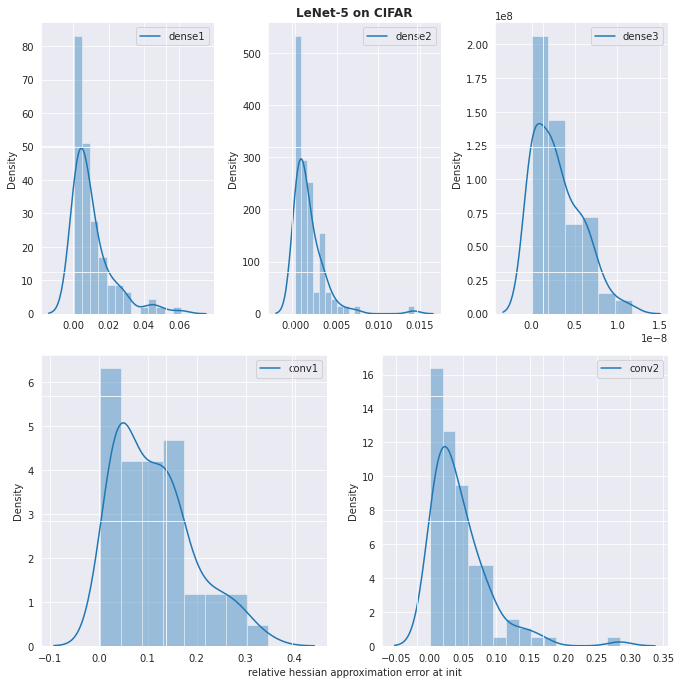

In [13]:
fig = plt.figure(constrained_layout=False,figsize=(10,10))
gs = fig.add_gridspec(nrows=2, ncols=6)#, left=0.05, right=0.48, wspace=0.05)
ax1 = fig.add_subplot(gs[0,0:2])
ax2 = fig.add_subplot(gs[0,2:4])
ax3 = fig.add_subplot(gs[0,4:6])
ax4 = fig.add_subplot(gs[1,0:3])
ax5 = fig.add_subplot(gs[1,3:6])
axs = [ax1,ax2,ax3,ax4,ax5]
names = ['dense1','dense2','dense3','conv1','conv2']

for ax,name in zip(axs,names):
  sn.distplot(diffs[name],ax=ax)
  ax.legend([name])

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('relative hessian approximation error at init')
plt.title('LeNet-5 on CIFAR',fontweight="bold")
fig.tight_layout()
plt.show()

## Hessian-driven initialization

Below we estimate hessians at init to do a custom initialization - improving upon established initializers!

In [14]:
import seaborn as sn

## prepare data
(x_train,y_train),_ = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255
x_train = x_train - x_train.mean(0)
y_train = y_train.astype('int32')
x_train = x_train.astype('float32')
data = tf.data.Dataset.from_tensor_slices((x_train,y_train.reshape(-1,1))).batch(64).repeat(2)

hforms = []
losses = []

## build model; try different inits

setups = [(tf.keras.activations.relu,tf.keras.initializers.truncated_normal(stddev=0.3),'relu + *hessian driven stddev*'),
          (tf.keras.activations.relu,tf.keras.initializers.he_normal(),'relu + He normal'),
          (tf.keras.activations.tanh,tf.keras.initializers.glorot_uniform(),'tanh + Glorot'),
          (tf.keras.activations.tanh,tf.keras.initializers.orthogonal(),'tanh + Orthogonal'),
          (tf.keras.activations.tanh,tf.keras.initializers.orthogonal(),'relu + Orthogonal')
          ]

#activations = {'sigmoid':tf.keras.activations.sigmoid,'relu':tf.keras.activations.relu,'tanh':tf.keras.activations.tanh}

for setup in setups:

  activation,init,name = setup

  inputs = tf.keras.Input(shape=(28,28,))
  flatt = tf.keras.layers.Flatten()(inputs)
  if name == 'relu + *hessian driven stddev*':
    init1 = 'glorot_uniform'
  else:
    init1 = init
  init2,init3 = init,init
  dense1 = tf.keras.layers.Dense(128,name='dense1',activation=activation,kernel_initializer=init1)(flatt)
  dense2 = tf.keras.layers.Dense(84,name='dense2',activation=activation,kernel_initializer=init2)(dense1)
  dense3 = tf.keras.layers.Dense(10,name='dense3',activation='linear',kernel_initializer=init3)(dense2)
  logits = dense3
  model = tf.keras.Model(inputs=inputs, outputs=logits)

  ## prepare optimizer
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
  vars = model.trainable_variables

  layers = ['dense1','dense2','dense3']

  ## estimate hessian at init
  for layer in layers:
    
    for _ in range(100):
    
      reset_kernels(model)
      
      x,y = x_train[:100],y_train[:100]
      var = model.get_layer(layer).kernel
      vec = grad(model,var,x,y)
      
      h = hform(model,var,vec,x,y)
      h = h/tf.linalg.norm(vec)**2

      hforms.append( (name,layer,h.numpy()) )

  ## train

  for i,(x,y) in enumerate(data):
    
    grads = grad(model,vars,x,y)
    optimizer.apply_gradients(zip(grads,vars))

    if i%100 == 0:
      loss = logp(model(x_train),y_train)
      losses.append( (name,i,loss.numpy()) )

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

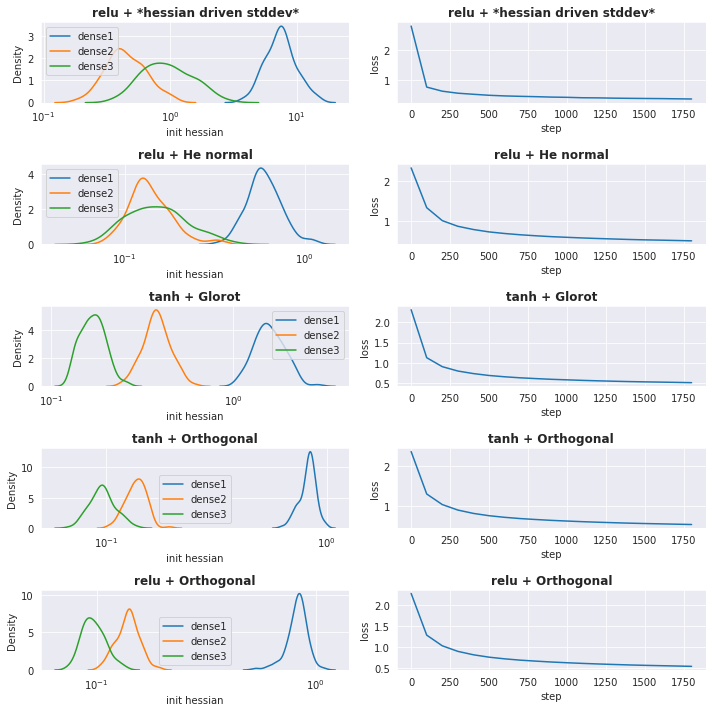

In [15]:
import pandas as pd

hforms = pd.DataFrame(hforms)
hforms.columns = ['setup','layer','init hessian']
losses = pd.DataFrame(losses)
losses.columns = ['setup','step','loss']

sn.set_style("darkgrid")

fig,axs = plt.subplots(len(setups),2,figsize=(10,10))

for (i,setup) in enumerate(setups):
  _,_,s = setup
  title = s
  ax = axs[i][0]
  for l in layers:
    mask = (hforms['setup'] == s) & (hforms['layer'] == l)
    sn.kdeplot(x=hforms[mask]['init hessian'],ax=ax,log_scale=True,label=l)
    ax.set_title(title,fontweight='bold')
    ax.legend()

  mask = losses['setup'] == s
  ax = axs[i][1]
  sn.lineplot(losses[mask]['step'],-losses[mask]['loss'],ax=ax)
  ax.set_title(title,fontweight='bold')

fig.tight_layout()

In [16]:
step_max = losses['step'].max()
-losses.groupby('setup')[['loss']].max()

,loss
setup,
relu + *hessian driven stddev*,0.387496
relu + He normal,0.492459
relu + Orthogonal,0.535332
tanh + Glorot,0.509914
tanh + Orthogonal,0.535056
